In [2]:
# Utilis 
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# ML
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
# CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import pytorch_lightning as pl
import torchmetrics
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/Users/praneetsurabhi/miniconda3/envs/ECEN/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/praneetsurabhi/miniconda3/envs/ECEN/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/praneetsurabhi/miniconda3/envs/ECEN/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <11B0C459-A0A5-32C4-83B5-9A167FD993BF> /Users/praneetsurabhi/miniconda3/envs/ECEN/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [25]:
class PCamDataset(Dataset):
    def __init__(self, images, labels, transform_train = None, transform_val = None, transform_test = None):
        # Making sure that the variables are of the right type  
        self.images = images if isinstance(images, np.ndarray) else np.array(images)
        self.labels = labels.values if isinstance(labels, pd.DataFrame) else np.array(labels)
        
        # Transformations
        self.transform_train = transform_train
        self.transform_val = transform_val
        self.transform_test = transform_test

    def __len__(self):
        # It returns the number of samples in our dataset
        return len(self.images) 
    
    def __getitem__(self, idx):
        """
            Retrieves the image and corresponding text encoding at the given index.
            Args:
                idx (int): The index of the sample to retrieve.
            Returns:
                tuple: A tuple containing the image and text encoding.
            """

        image = self.images[idx]
        label = self.labels[idx]

        if self.transform_train:
            image = self.transform_train(image)
        if self.transform_val:
            image = self.transform_val(image)
        if self.transform_test:
            image = self.transform_test(image)

        return image, label

In [26]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

In [27]:
x_train = np.load('Data/x_train.npy')
x_val = np.load('Data/x_val.npy')
x_test = np.load('Data/x_test.npy')
y_train = pd.read_pickle('Data/y_train.pkl')
y_val = pd.read_pickle('Data/y_val.pkl')
y_test = pd.read_pickle('Data/y_test.pkl')

In [28]:
print('x train shapes:', x_train.shape)
print('y train shapes:', y_train.shape)
print('x validation shapes:', x_val.shape)
print('y validation shapes:', y_val.shape)
print('x test shapes:', x_test.shape)
print('y test shapes:', y_test.shape)

x train shapes: (40000, 96, 96, 3)
y train shapes: (40000, 1)
x validation shapes: (5000, 96, 96, 3)
y validation shapes: (5000, 1)
x test shapes: (5000, 96, 96, 3)
y test shapes: (5000, 1)


In [6]:
# Function for plotting
def plot_images_with_labels(x_data, y_data, malignant_indx, non_malignant_indx):
    # Parameters
    nrows = 2
    ncols = 5
    # Creating the subplot
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 8))
    fig.suptitle('Histopathologic scans', fontsize=20)

    for row in range(nrows):
        for col in range(ncols):
            # Determine the current row: 
              # First row for non-malignant cases
              # Second row for malignant cases
            # and save the current index from the correct subset
            if row == 0:
                index = non_malignant_indx[col]
            else:  
                index = malignant_indx[col]

            # Retrieve the corresponding image and label
            image = x_data[index]
            label = y_data.iloc[index, 0]

            # Plot the image 
            ax[row, col].imshow(image)
            # with a bounding box based on the label (red for Malignant and blue for Non-Malignant)
            box_color = 'r' if label == 1 else 'b'
            box = patches.Rectangle((32, 32), 32, 32, linewidth=4, edgecolor=box_color,
                                    facecolor='none', linestyle=':', capstyle='round')
            ax[row, col].add_patch(box)
            ax[row, col].set_title(f'Label: {label}', color='white')

    # Add a legend
    legend_elements = [patches.Patch(facecolor='none', edgecolor='r', linewidth=2, label='Malignant (Tumor)'),
                       patches.Patch(facecolor='none', edgecolor='b', linewidth=2, label='Non-Malignant (No Tumor)')]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0.5, fontsize='large')

    plt.show()

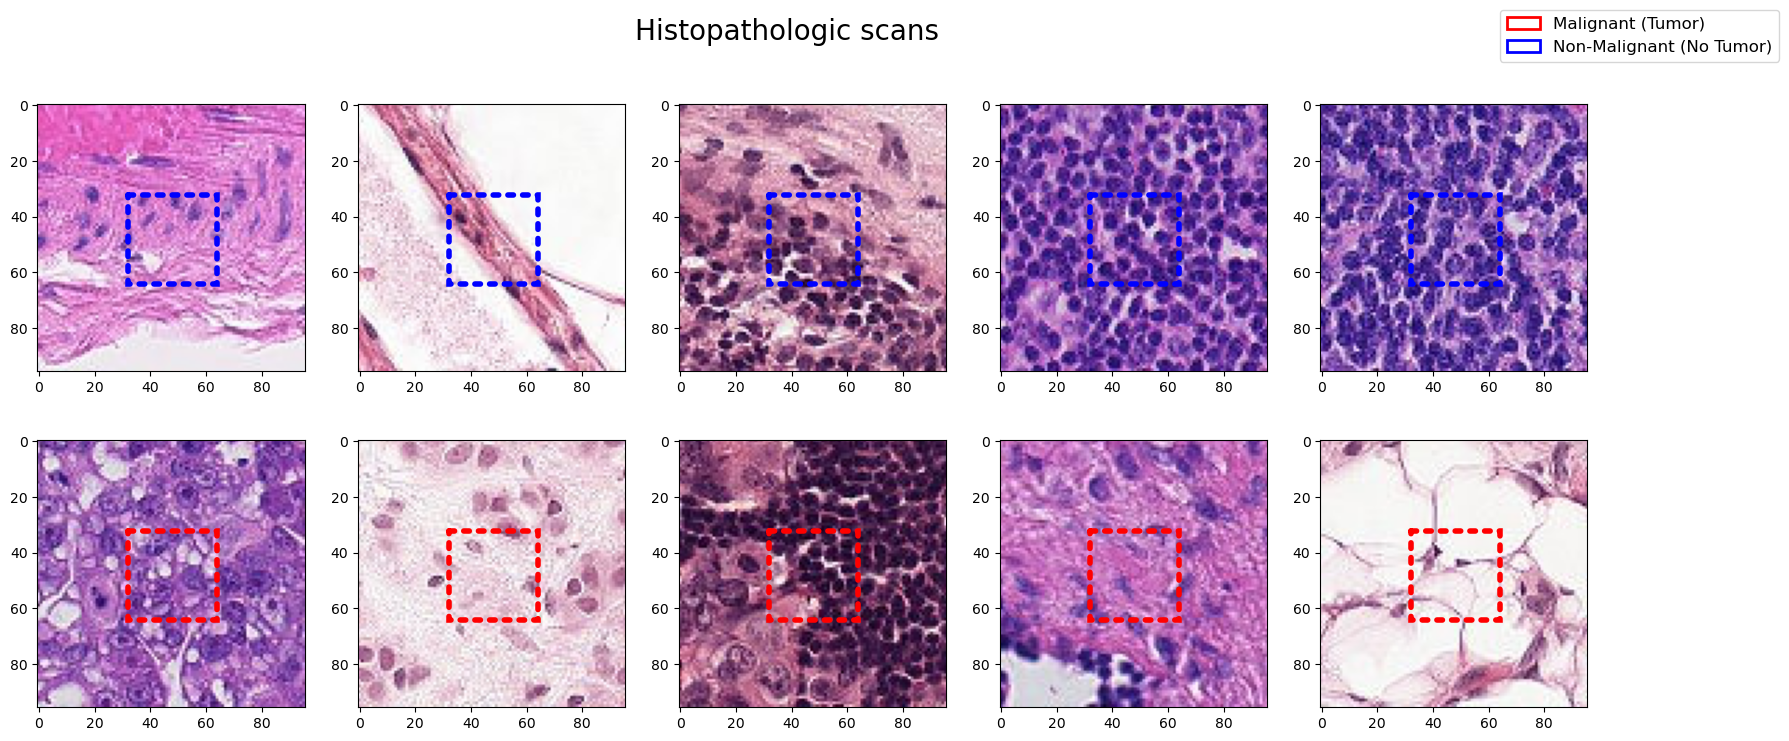

In [7]:
# All indices
malignant_indices = np.where(y_train == 1)[0]
non_malignant_indices = np.where(y_train == 0)[0]

# Randomly sample 5 malignant and 5 non-malignant indices
rnd_malignant_indx = np.random.choice(malignant_indices, size=5, replace=False)
rnd_non_malignant_indx = np.random.choice(non_malignant_indices, size=5, replace=False)

# Plot
plot_images_with_labels(x_train, y_train, rnd_malignant_indx, rnd_non_malignant_indx)

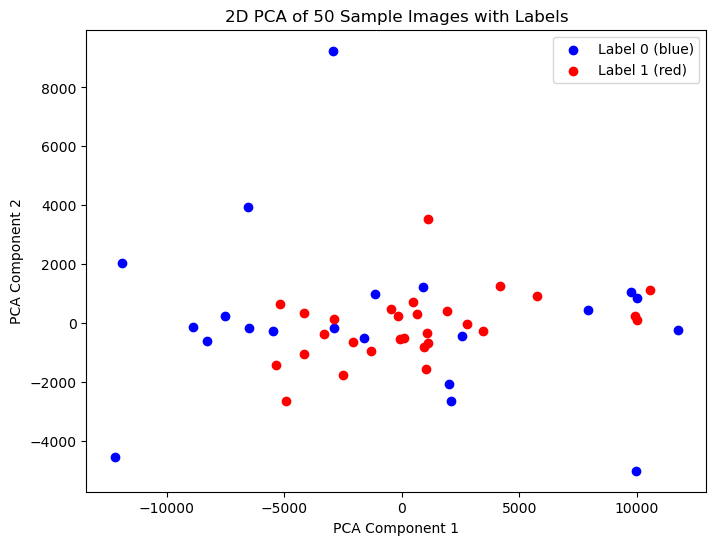

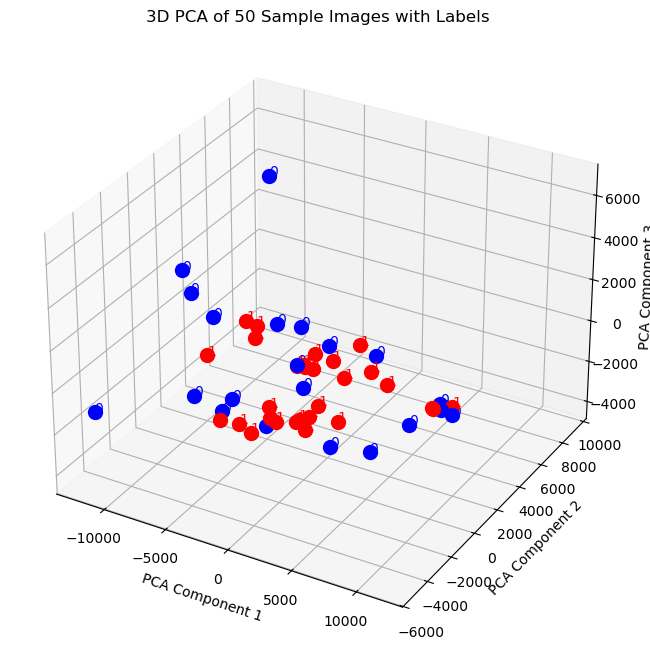

In [8]:
sample = 50
x_train_subset = x_train[:sample]  # Select first 5 samples for simplicity
y_train_subset = y_train[y_train.columns[0]][:sample].values

# Step 2: Flatten each image (96, 96, 3) -> (27648,)
x_train_flat = x_train_subset.reshape(sample, -1)  # Shape: (5, 27648)


# Step 3: Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_flat)  # Shape: (5, 2)

# Step 4: Plot the 2D PCA result with colors based on y_train labels
plt.figure(figsize=(8, 6))
for i, label in enumerate(y_train_subset):
    color = 'blue' if label == 0 else 'red'
    plt.scatter(x_train_pca[i, 0], x_train_pca[i, 1], color=color, label=f"Label {label}" if i == 0 else "")

# Add labels, title, and legend
plt.title(f'2D PCA of {sample} Sample Images with Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(['Label 0 (blue)', 'Label 1 (red)'], loc='upper right')
plt.show()

pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train_flat)  # Shape: (5, 3)

# Step 4: Plot the 3D PCA result with colors based on y_train labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(y_train_subset):
    color = 'blue' if label == 0 else 'red'
    ax.scatter(x_train_pca[i, 0], x_train_pca[i, 1], x_train_pca[i, 2], color=color, s=100)
    ax.text(x_train_pca[i, 0] + 0.1, x_train_pca[i, 1] + 0.1, x_train_pca[i, 2] + 0.1, str(label), color=color)

# Add labels, title, and legend
ax.set_title(f'3D PCA of {sample} Sample Images with Labels')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

### Interpretation of 2D and 3D PCA of PCAM Images

#### Observations from 2D PCA
- **Cluster Overlap**: The red (malignant) and blue (non-malignant) points show some overlap, indicating that the first two principal components do not completely separate the two classes. This suggests that malignancy may not be entirely distinguishable based solely on these two components.
- **Variance**: The spread of data across the two components shows that the images vary along these axes, but the lack of clear class division implies that additional components or features may be required for better discrimination.

#### Observations from 3D PCA
- **Increased Separation in 3D Space**: Adding a third component provides more depth, leading to slight improvements in class separability. However, significant overlap remains between the red and blue points, indicating that the classes aren't fully separable even in 3D space.
- **Feature Complexity**: The overlap suggests that distinguishing malignant from non-malignant cases likely requires complex, multi-dimensional features. PCA, a linear transformation, may not capture all the intricate patterns that could aid in separation.

#### Insights for Model Development
- **High-Dimensional Feature Space**: The overlap in PCA plots indicates that separating malignant and non-malignant images requires a high-dimensional feature space, where nonlinear relationships are better captured by models like CNNs.
- **Need for Deep Learning**: CNNs are suitable for identifying subtle patterns across multiple layers, potentially extracting features that PCA cannot capture. The PCA analysis underscores that raw pixel values (or their linear combinations) alone are insufficient for clear class separation, highlighting the necessity of CNN's hierarchical and nonlinear feature extraction.

In summary, while PCA provides a glimpse into the data structure, the overlap in these PCA plots reinforces the importance of using a CNN model for more effective feature extraction and classification in the PCAM dataset.


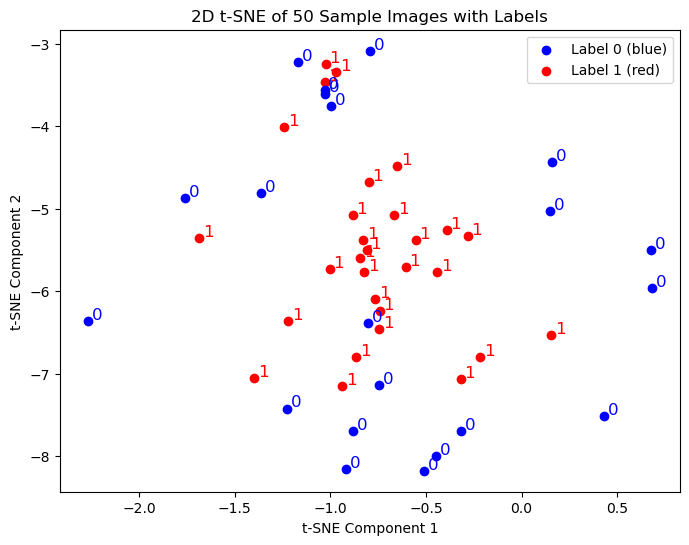

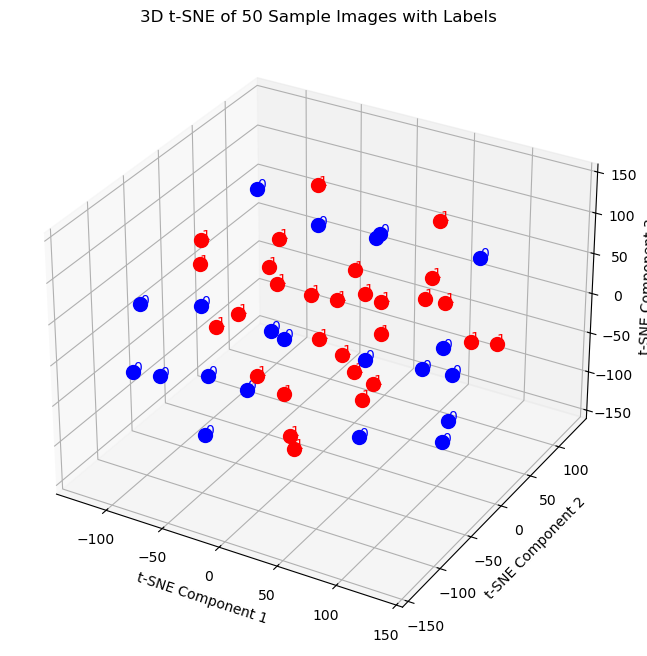

In [9]:
tsne_2d = TSNE(n_components=2, random_state=42)
x_train_tsne_2d = tsne_2d.fit_transform(x_train_flat)

# Step 4: Plot the 2D t-SNE result with colors based on y_train labels
plt.figure(figsize=(8, 6))
for i, label in enumerate(y_train_subset):
    color = 'blue' if label == 0 else 'red'
    plt.scatter(x_train_tsne_2d[i, 0], x_train_tsne_2d[i, 1], color=color, label=f"Label {label}" if i == 0 else "")
    plt.text(x_train_tsne_2d[i, 0] + 0.02, x_train_tsne_2d[i, 1] + 0.02, str(label), fontsize=12, color=color)

# Add labels, title, and legend
plt.title(f'2D t-SNE of {sample} Sample Images with Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(['Label 0 (blue)', 'Label 1 (red)'], loc='upper right')
plt.show()

tsne_3d = TSNE(n_components=3, random_state=42)
x_train_tsne_3d = tsne_3d.fit_transform(x_train_flat)

# Step 4: Plot the 3D t-SNE result with colors based on y_train labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(y_train_subset):
    color = 'blue' if label == 0 else 'red'
    ax.scatter(x_train_tsne_3d[i, 0], x_train_tsne_3d[i, 1], x_train_tsne_3d[i, 2], color=color, s=100)
    ax.text(x_train_tsne_3d[i, 0] + 0.1, x_train_tsne_3d[i, 1] + 0.1, x_train_tsne_3d[i, 2] + 0.1, str(label), color=color)

# Add labels, title, and legend
ax.set_title(f'3D t-SNE of {sample} Sample Images with Labels')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()

### Interpretaion of 2D and 3D t-SNE

- t-SNE remains consistent with the observations from PCA. It emphasizes on a need for a complex learning model due to lack separability in any form. A CNN model will be more effective for feature extraction and classification in the PCAM dataset.

In [29]:
def compute_mean_std(dataset):
    # Compute mean and std along the height, width, and sample axes
    mean_values = np.mean(dataset, axis=(0, 1, 2)) / 255.0
    std_values = np.std(dataset, axis=(0, 1, 2)) / 255.0

    return mean_values, std_values

# Calculate mean and std for each dataset
mean_values_train, std_values_train = compute_mean_std(x_train)
mean_values_val, std_values_val = compute_mean_std(x_val)
mean_values_test, std_values_test = compute_mean_std(x_test)

# Split mean values and std values into separate components for RGB channels
mean_value_R_train, mean_value_G_train, mean_value_B_train = mean_values_train
std_value_R_train, std_value_G_train, std_value_B_train = std_values_train

mean_value_R_val, mean_value_G_val, mean_value_B_val = mean_values_val
std_value_R_val, std_value_G_val, std_value_B_val = std_values_val

mean_value_R_test, mean_value_G_test, mean_value_B_test = mean_values_test
std_value_R_test, std_value_G_test, std_value_B_test = std_values_test

# Display results for verification
print("Train mean values:", mean_values_train)
print("Train std values:", std_values_train)
print("Validation mean values:", mean_values_val)
print("Validation std values:", std_values_val)
print("Test mean values:", mean_values_test)
print("Test std values:", std_values_test)

Train mean values: [0.70105999 0.53995758 0.69499052]
Train std values: [0.2346119  0.27637937 0.21190233]
Validation mean values: [0.70243598 0.53704146 0.69387274]
Validation std values: [0.23160563 0.27399555 0.21017143]
Test mean values: [0.68060977 0.52425956 0.69440137]
Test std values: [0.24115132 0.28238104 0.2101764 ]


In [30]:
# Train transformation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[mean_value_R_train, mean_value_G_train, mean_value_B_train], std=[std_value_R_train, std_value_G_train, std_value_B_train])
])

transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[mean_value_R_val, mean_value_G_val, mean_value_B_val], std=[std_value_R_val, std_value_G_val, std_value_B_val])
])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[mean_value_R_test, mean_value_G_test, mean_value_B_test], std=[std_value_R_test, std_value_G_test, std_value_B_test])
])

In [31]:
train_dataset = PCamDataset(images= x_train, labels= y_train, transform_train = transform_train)
valid_dataset = PCamDataset(images= x_val,   labels= y_val,   transform_val= transform_val )
test_dataset = PCamDataset(images= x_test,   labels= y_test,   transform_test = transform_test )

In [32]:
# Create DataLoader for each 
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False,  num_workers=0)

In [42]:
class PCamClassification(pl.LightningModule):
    # Initialization
    def __init__(self):
        super(PCamClassification, self).__init__()
        # First 2D convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(16)
        # Second 2D convolutional layer
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        # Batch normalization
        self.bn2 = nn.BatchNorm2d(16)
        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Other convolutional layers
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.dropout = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(256, 1)
        
        # Metrics
        # Binary Accuracy Metric
        self.train_acc = torchmetrics.classification.BinaryAccuracy(threshold=0.5, multidim_average='global')
        self.valid_acc = torchmetrics.classification.BinaryAccuracy(threshold=0.5, multidim_average='global')
        
        # Create lists to hold the outputs of *_step
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
        # Create lists for the testing
        self.test_losses = []
        self.test_accs = []
        
        # Create lists to store averages for plotting
        self.avg_train_losses = []
        self.avg_train_accs = []
        self.avg_val_losses = []
        self.avg_val_accs = []
        

    # Forward Method: defining the network flow: x represents our data
    def forward(self, x):
        # Pass data through conv1 + batch norm + rectified-linear activation 
        x = F.relu(self.bn1(self.conv1(x)))
        # Pass data through conv2 + batch norm + rectified-linear activation 
        x = F.relu(self.bn2(self.conv2(x)))
        # Run max pooling over x
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool(x)
        
        # Flatten x 
        x = x.view(-1, 128 * 6 * 6)
        # relu activation + fully connected layer
        x = F.relu(self.fc1(x))
        # droput function and last fully connected layer
        x = self.dropout(x)
        x = self.fc2(x)  
        return x
    
    # Training step
    def training_step(self, batch, batch_idx):
        # Extract input data (x) and true labels (y) from the batch 
        x, y = batch
        # Predictions
        y_hat = self(x)
        # Loss function
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        # Accuracy computation
        acc = self.train_acc(y_hat, y)
        
        # Add the outputs to the lists
        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        
        # Return the result of the loss function
        return loss
    
    # Validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        acc = self.valid_acc(y_hat, y)
        
        # Add the outputs to the lists
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())
        
        return loss
    
    def on_train_epoch_end(self):
        # Averaging the train losses and accuracies 
        avg_train_loss = np.mean(self.train_losses)
        avg_train_acc = np.mean(self.train_accs)

        # Calculate epoch-level metrics and log them, use log().
        self.log('train_loss', avg_train_loss, on_epoch=True, prog_bar=True,sync_dist=True)
        self.log('train_acc', avg_train_acc, on_epoch=True, prog_bar=True, sync_dist=True)

        # Save averages for plotting
        self.avg_train_losses.append(avg_train_loss)
        self.avg_train_accs.append(avg_train_acc)

        # Clear the memory for the next epoch
        self.train_losses.clear()
        self.train_accs.clear()

    def on_validation_epoch_end(self):
        # Averaging the validation losses and accuracies
        avg_val_loss = np.mean(self.val_losses)
        avg_val_acc = np.mean(self.val_accs)

        # Log the averages
        self.log('val_loss', avg_val_loss, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('val_acc', avg_val_acc, on_epoch=True, prog_bar=True, sync_dist=True)

        # Save averages for plotting
        self.avg_val_losses.append(avg_val_loss)
        self.avg_val_accs.append(avg_val_acc)

        # Clear the memory for the next epoch
        self.val_losses.clear()
        self.val_accs.clear()
    
   # Prediction Loop
    def predict(self, dataloader):
        # Set model to eval mode 
        self.eval()
        
        # Lists to store true labels and predicted probabilities
        y_pred = []
        y_true = []
        
        with torch.no_grad():
            # Loop through the batches in the provided data loader
            for batch in tqdm(dataloader):
                # Extract input data (x) and true labels (y) from the batch
                x, y = batch
                
                # Convert true labels to a NumPy array and extend the list
                y_true.extend(y.detach().cpu().numpy().tolist())
                
                # Forward pass through the model
                output = self.forward(x)

                # Apply sigmoid activation to get probabilities
                probabilities = torch.sigmoid(output)

                # Binarize predictions to 0 and 1 based on a threshold (0.5 in this case)
                predictions = (probabilities >= 0.4).long()

                # Extend the list with predicted labels
                y_pred.extend(predictions.view(-1).detach().cpu().numpy().tolist())
        
        # Set the model back to the training mode
        self.train()
        # Return the predicted probabilities as a NumPy array
        return np.array(y_pred)

    # Optimizers 
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=1e-5)

In [43]:
filename_without_extension = 'Model1-Variant1' #Insert the filename without extension
best_model = torch.load(f'Best_Model/{filename_without_extension}.pth')

/var/folders/vd/335h5jcj7cg0s8l8_29j80dm0000gn/T/ipykernel_93345/2413677817.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f'Best_Model/{filenam

In [44]:
best_model = best_model.cpu()
y_pred = best_model.predict(test_loader)

100%|██████████| 79/79 [00:08<00:00,  8.78it/s]


In [45]:
accuracy = round(accuracy_score(y_test, y_pred) * 100, 3)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a dataframe
data = {'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [accuracy, precision, recall, f1_score]}
metrics_df = pd.DataFrame(data)
metrics_df

Metric      Value
0   Accuracy  86.480000
1  Precision   0.835541
2     Recall   0.908400
3   F1 Score   0.870448

In [3]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

NameError: name 'y_test' is not defined

In [19]:
# Function to plot validation accuracy
def plot_validation_accuracy(avg_val_accs):
    epochs = range(0, len(avg_val_accs))
    plt.plot(epochs, avg_val_accs, '#2b8cbe', marker='x' , label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy vs. Epochs')
    plt.show()

# Function to plot combined losses    
def plot_combined_losses(avg_train_losses, avg_val_losses):
    epochs = range(0, len(avg_train_losses))
    plt.plot(epochs, avg_train_losses, '#2b8cbe', marker='x', label='Training Loss')
    epochs = range(0, len(avg_val_losses))
    plt.plot(epochs, avg_val_losses, '#fc5c5c', marker='x', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses vs. Epochs')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, conf_matrix):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

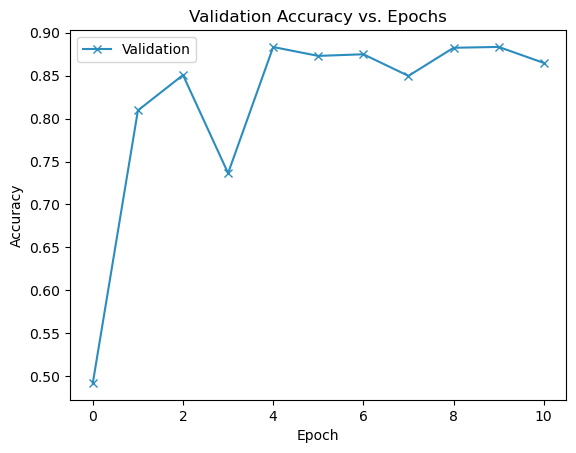

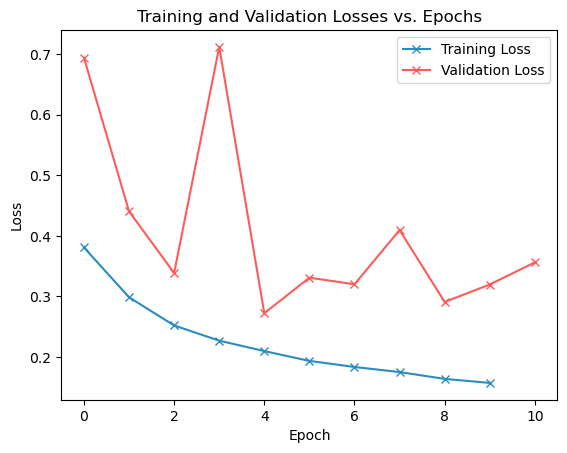

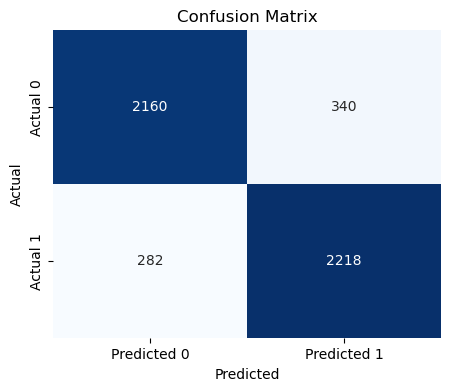

In [20]:
plot_validation_accuracy(best_model.avg_val_accs)
plot_combined_losses(best_model.avg_train_losses, best_model.avg_val_losses)
plot_confusion_matrix(y_test, y_pred, conf_matrix)

In [21]:
index = 50
single_image = x_test[index]
single_label = y_test.iloc[index, 0] 

image_tensor = torch.tensor(single_image).permute(2, 0, 1).unsqueeze(0)
label_tensor = torch.tensor(single_label)
image_tensor = image_tensor / 255.0 if image_tensor.max() > 1 else image_tensor

print("Image tensor shape:", image_tensor.shape) 
print("Label tensor:", label_tensor)

Image tensor shape: torch.Size([1, 3, 96, 96])
Label tensor: tensor(1, dtype=torch.uint8)


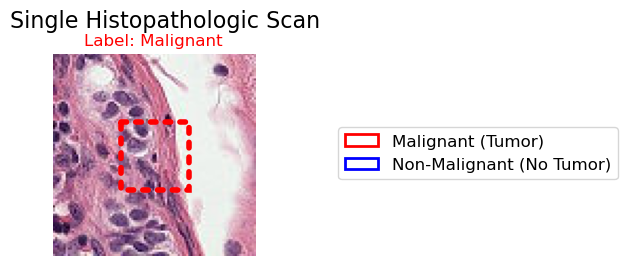

In [22]:
def plot_single_image_with_label(image_tensor, label):
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(figsize=(3, 3))
    fig.suptitle('Single Histopathologic Scan', fontsize=16)

    ax.imshow(image_np)
    box_color = 'r' if label == 1 else 'b'
    box = patches.Rectangle((32, 32), 32, 32, linewidth=4, edgecolor=box_color,
                            facecolor='none', linestyle=':', capstyle='round')
    ax.add_patch(box)
    
    # Set title based on the label
    ax.set_title(f'Label: {"Malignant" if label == 1 else "Non-Malignant"}', color=box_color)
    ax.axis('off')  # Turn off axes for a cleaner look
    
    # Add a legend outside the plot area on the right
    legend_elements = [patches.Patch(facecolor='none', edgecolor='r', linewidth=2, label='Malignant (Tumor)'),
                       patches.Patch(facecolor='none', edgecolor='b', linewidth=2, label='Non-Malignant (No Tumor)')]
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.5, fontsize='large')

    plt.subplots_adjust(right=0.8)
    plt.show()

plot_single_image_with_label(image_tensor, label_tensor.item())


Number of activation layers captured: 6


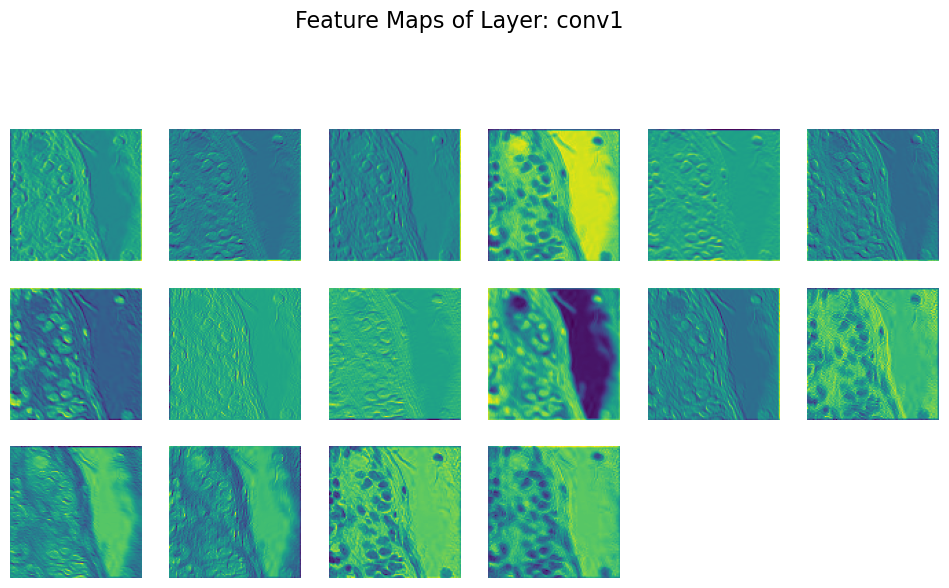

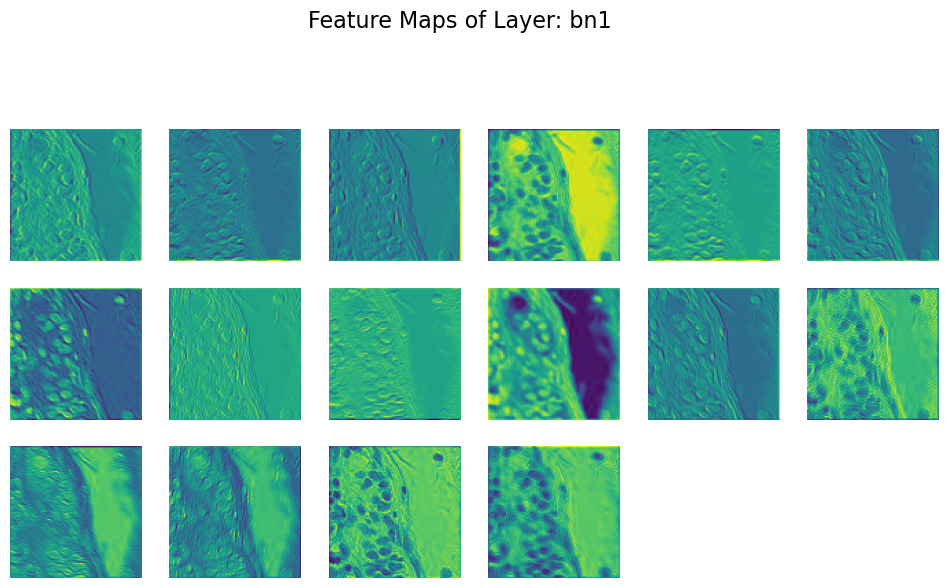

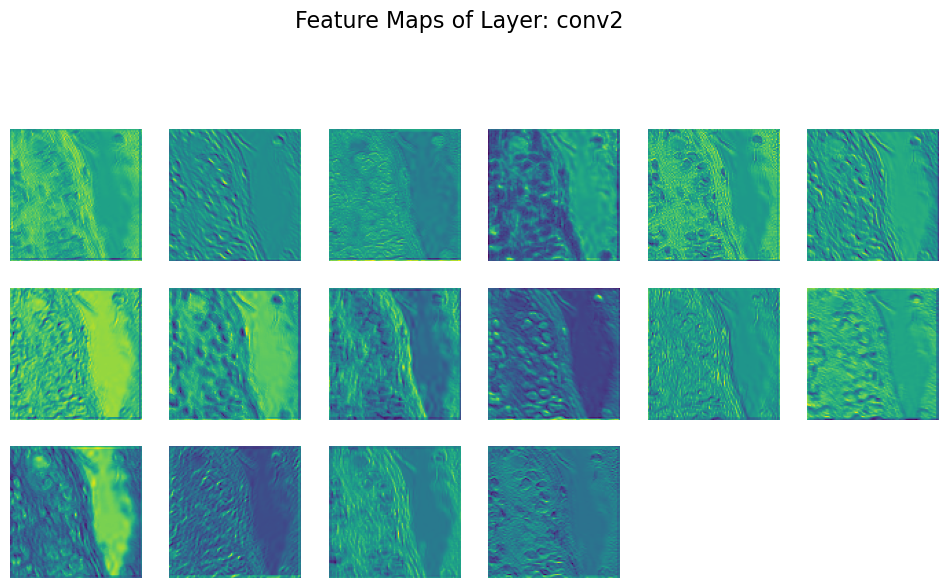

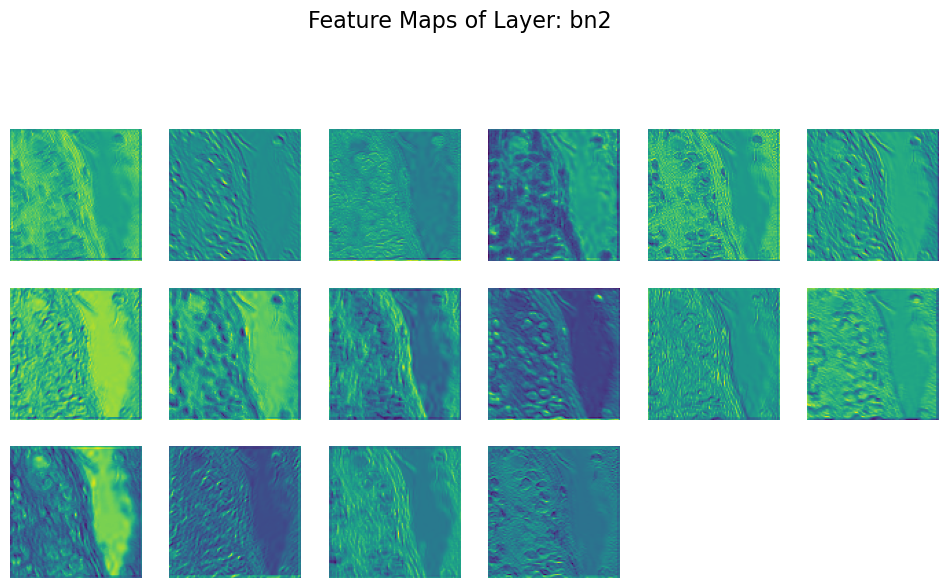

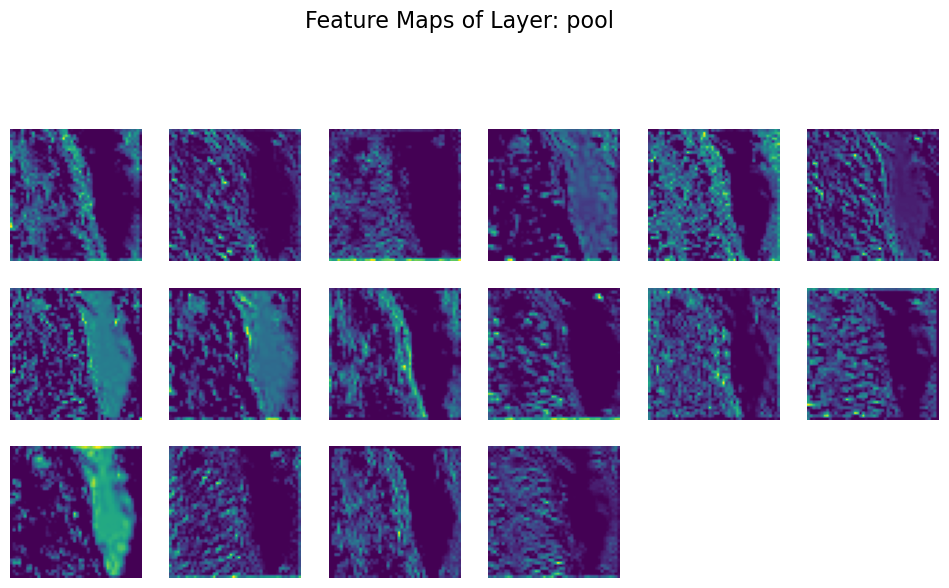

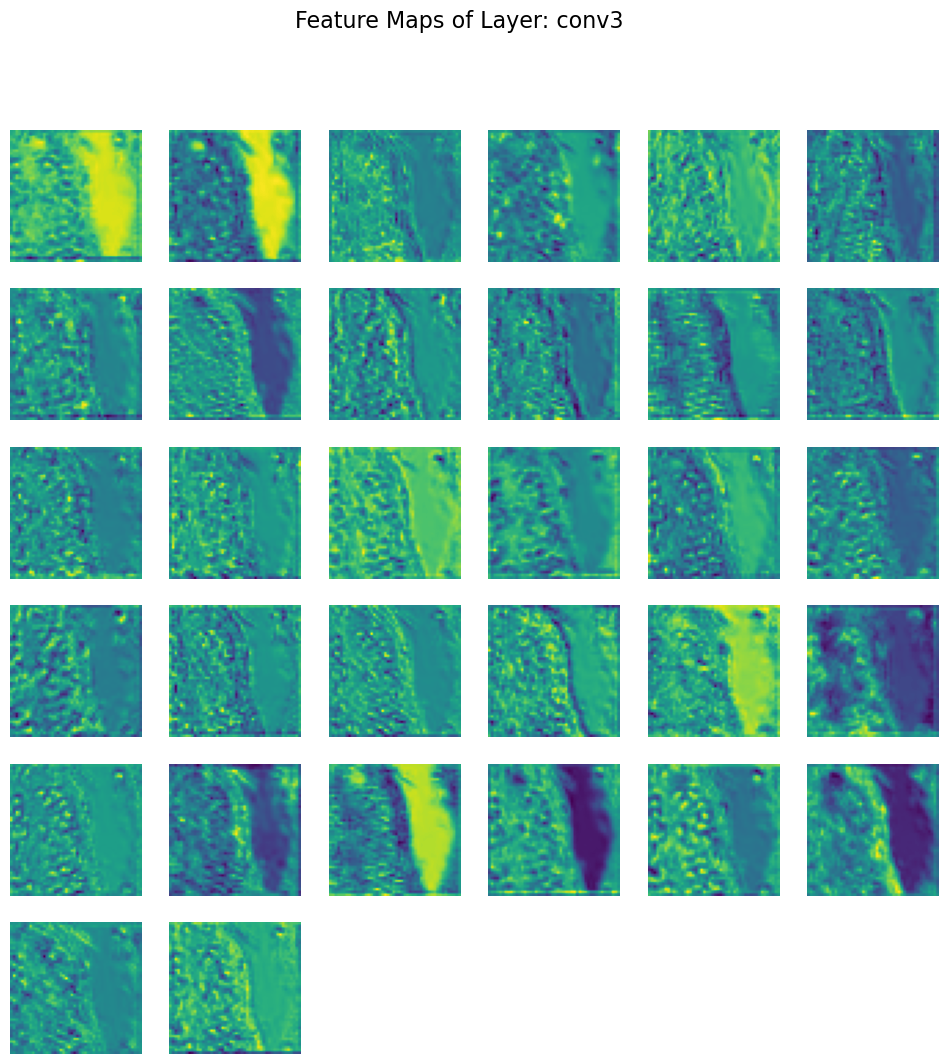

In [23]:
activations = {}

# Hook function to capture activations once per layer
def hook_fn(name):
    def hook(module, input, output):
        if name not in activations:
            activations[name] = output  # Store only the first activation for each layer
    return hook

# Define layer names and layers
layer_strings = ['conv1', 'bn1', 'conv2', 'bn2', 'pool', 'conv3']
layers = [best_model.conv1, best_model.bn1, best_model.conv2, best_model.bn2, best_model.pool, best_model.conv3]
hooks = [layer.register_forward_hook(hook_fn(name)) for layer, name in zip(layers, layer_strings)]

# Forward pass to capture activations
_ = best_model(image_tensor)  # Ensure `image_tensor` is of shape (1, 3, 96, 96)
print("Number of activation layers captured:", len(activations))

# Plot the activations for each layer
for layer_name, activation in activations.items():
    # Remove batch dimension and detach
    activation = activation.squeeze(0).detach()
    num_filters = activation.shape[0]

    # Set up the figure for visualization
    plt.figure(figsize=(12, 12))
    for i in range(min(num_filters, 36)):  # Display up to 36 filters
        plt.subplot(6, 6, i + 1)
        plt.imshow(activation[i].cpu().numpy(), cmap='viridis')
        plt.axis('off')
    
    # Set the title to indicate which layer this is
    plt.suptitle(f"Feature Maps of Layer: {layer_name}", fontsize=16)
    plt.show()

# Remove hooks after capturing activations
for hook in hooks:
    hook.remove()

### Model Interpretability: Feature Maps from CNN Layers

#### Early Convolutional Layers (conv1 and conv2)
- **Low-Level Feature Extraction**: The initial layers capture fundamental features such as edges, textures, and simple patterns. These low-level characteristics help the model build an initial "map" of the image, which is essential for identifying structural differences between malignant and non-malignant areas.
- **Importance for Prediction**: By identifying edges and textures, these layers allow the model to start distinguishing cellular structures and basic textures, helping it recognize early indicators of malignancy.

#### Batch Normalization Layers (bn1 and bn2)
- **Normalization**: Batch normalization layers standardize the outputs from the convolutional layers, stabilizing the learning process. This helps reduce the model's sensitivity to variations in input data, which can be particularly useful in medical imaging where lighting, staining, or tissue quality can vary.
- **Generalization**: Normalization contributes to the model’s ability to generalize across diverse datasets by making activations consistent, ensuring that each layer is processing inputs on a similar scale. This aids in achieving reliable performance on unseen data and increases interpretability by making feature maps more stable and meaningful.

#### Pooling Layer (Downsampling)
- **Dimensionality Reduction**: The pooling layer reduces the spatial dimensions of the feature maps, focusing on prominent patterns while discarding finer, less critical details. This simplification is useful for retaining essential features and reducing computational load.
- **Pattern Emphasis**: After pooling, the model is directed towards broader and more prominent patterns rather than fine-grained textures. These high-activation regions likely correspond to significant structures or patterns in the image that could indicate malignancy, such as clusters of irregular cells.
- **Regularization and Robustness**: Pooling indirectly regularizes the model, helping it generalize better by making it less sensitive to small, irrelevant details or noise in the image. This robustness is crucial in healthcare, where subtle differences in imaging conditions can otherwise lead to inconsistent predictions.


These feature maps offer a window into how the CNN model progressively builds a hierarchical understanding of the image. Starting with low-level features in early convolutional layers, moving through normalized representations, and finally focusing on high-level patterns through pooling, the model incrementally forms a deeper, more abstract representation of the input. This hierarchical structure is essential for accurately distinguishing malignant from non-malignant samples, and understanding it helps increase trust in the model's predictions for critical applications like cancer detection.


### Business Insights: Practical Implications of Malignancy Prediction Model for a Company

PCAM dataset and CNN model for predicting malignancy has several practical implications for a healthcare or medical imaging company:

1. **Enhanced Diagnostic Accuracy**:
   - **Faster Diagnoses**: A CNN model capable of accurately predicting malignancy can speed up diagnostic processes, potentially reducing the initial workload for pathologists and radiologists. However, cancer detection is a highly sensitive and important task that always requires validation from a trained physician. By incorporating insights from this model, healthcare professionals can make more informed and timely decisions, enhancing both accuracy and efficiency in patient care.
   - **Reduced Human Error**: Automated detection can minimize the chances of missed diagnoses, leading to more accurate results and improved patient outcomes.

2. **Cost Efficiency**:
   - **Resource Optimization**: Automating the screening of malignant tissues allows for more efficient use of healthcare professionals’ time, enabling them to focus on cases requiring further analysis.
   - **Reduction in Operational Costs**: By automating initial screenings, healthcare providers could potentially save costs on manual reviews and re-testing, leading to better resource allocation.

3. **Scalability**:
   - **High Throughput Screening**: This model enables rapid processing of large volumes of pathology images, which can be crucial for high-demand facilities and large hospitals that require fast screening.
   - **Remote Diagnostics**: The model can facilitate telemedicine applications, enabling diagnosis support in regions lacking specialized healthcare providers.

4. **Market Competitiveness**:
   - **Cutting-edge AI Solutions**: A company that integrates such a model positions itself as a leader in AI-driven healthcare solutions, which can be a unique selling point to clients and investors.
   - **Attracting Partnerships and Funding**: Accurate, efficient diagnostic tools can attract partnerships with healthcare institutions and funding from organizations interested in advancing AI in healthcare.

5. **Compliance and Regulatory Value**:
   - **Consistent Standards**: AI models help maintain consistency in diagnosis, aiding compliance with regulatory standards in healthcare.
   - **Documentation and Data Tracking**: Machine learning models can support better data logging, which may streamline compliance with regulatory requirements, as all diagnoses can be tracked and audited.

6. **Patient Satisfaction and Trust**:
   - **Improved Outcomes**: Faster and more accurate diagnoses lead to improved patient outcomes, which enhance patient trust and satisfaction.
   - **Reduced Wait Times**: Automating part of the diagnostic process can reduce the time patients wait for results, leading to higher satisfaction rates and trust in the healthcare system.

7. **Transfer learning**:
   - We can use the same model and weights and train another model which is being used for similar purposes in medical fields.

This CNN model has the potential to make a meaningful impact on the efficiency, accuracy, and reach of healthcare services, providing tangible value both for healthcare providers and their patients.